# Hartree-Fock Algorithm For Simulating $HeH^{+}$ Molecule 

In [ ]:
#Imports 
import numpy as np 
import scipy as sp 
from scipy.special import erf 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

### Now we write a function for importing the xyz chemical data format. 

In [ ]:
def xyz_reader(file_name):
    #Reads an xyz file and returns the number of atoms, atom types and atom coordinates 

    file = open(file_name, 'r')

    number_of_atoms = 0
    atom_type = [] 
    atom_coordinates = []

    for idx,line in enumerate(file):
        #Get number of atoms 
        if idx==0:
            try:
                number_of_atoms = line.split()[0]
            except:
                print('xyz file not in correct format.')

        #Skip the coomment/blank line in the file 
        if idx == 1:
            continue 

        #Get atom types and positions for all other data entries in the file 
        #once we have already enumerated over the number of moleuclues and the comment line
        if idx>1:
            split = line.split()
            atom = split[0]
            coordinates=np.array([float(line.split()[1]),
                         float(line.split()[2]),
                         float(line.split()[3])])

            #Add this on to the atom information
            atom_type.append(atom)
            atom_coordinates.append(coordinates)

    file.close()

    return number_of_atoms, atom_type, atom_coordinates

we will now read in the xyz file for HeH. This file can be made in any text editor as long as the extension is .xyz. Note we are usin the experimentally determined bond length in a.u..

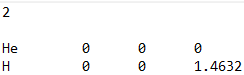

In [ ]:
#Ensure that this file directory is changed to match where you have stored the xyz file 
#and ensure that the xyz file is written in a plain text editor like nano on mac 
file_name = "/content/HeH_data.xyz"

In [ ]:
N_atoms, atoms, atom_coordinates = xyz_reader(file_name)

In [ ]:
print(N_atoms, atoms, atom_coordinates)

2 ['He', 'H'] [array([0., 0., 0.]), array([0.    , 0.    , 1.4632])]


we will choose the number of electrons in the system later as this is something we can set to whatever we like.

### Specify a basis set and number of electrons in the system.

We want to represent the elements of the slater orbitals as linear combinations of Gaussian orbitals. We do this because Gaussian orbitals can be integrated over easily. A Gaussian can be specified by only its centre and its exponent. We also need contraction coefficients which are simply the coefficients of the linear combination of the orbitals since the Slater orbitals are approximated by a linear sum of Gaussian functions. The exponents and contraction coefficients are both optimised through a least squares procedure.  

The zeta coefficients are essentially the effective nuclear charge of the atom and have been optimised via the variational principle. 

In [ ]:
#Basis set variables 

#STO-nG (number of gaussians used to form a contracted gaussian orbital)
STOnG=3

#Dictionary of zeta values 
zeta_dict = {'H':[1.24], 'He':[2.0925], 'Li':[2.69,0.80], 'Be':[3.68,1.15],
             'B':[4.68, 1.50], 'C':[5.67, 1.72]} #Put zeta number in list to accomodate for possibly more basis sets 

#Dictionary containing the max quantum number of each atom
#for minimal basis STO-nG calculation
max_quantum_number= {'H':1, 'He':1, 'Li':2, 'Be':2, 'C':2}

#Gaussian contraction coefficients 
#Going up to 2s orbital 
#row represents 1s, 2s, etc...
D = np.array([[0.444635, 0.535328, 0.154329],
              [0.700115, 0.399513, -0.0999672]])

#Gaussian orbital exponents 
#Going up to 2s orbital 
alpha = np.array([[0.109818, 0.405771, 2.22766], 
                  [0.0751386, 0.231031, 0.994203]])

#Basis set size 
B=0 
for atom in atoms: 
    B += max_quantum_number[atom]

Some more book-keeping is below. More importantly, here is where we store the number of electrons. The storage of atom charges is required for calculation of the potential energy (although this is not that importan per se since the potential energy just raises the overall energy by a constant value).

In [ ]:
#Number of electrons - IMPORTANT 
N = 2 

#Keep a dictionary of charges 
charge_dict = {'H': 1, 'He': 2, 'Li':3, 'Be':4,'B':5,'C':6,'N':7,'O':8,'F':9,'Ne':10}

## Computing all the required integrals in the Gaussian basis. 

We want to employ multiple different tecnhiques to allow us to easily calculate the needed integrals. The first of those is the fact that the product of two gaussians is also a gaussian function. Allow us to write a function for this effect now


The unnormalised 1s primitive Gaussian at $\vec{R_A}$ is 
$$g_{1s}\left(\vec{r}-\vec{R_A}\right)=e^{-\alpha\left|\vec{r}-\vec{R_A}\right|^2}.$$
We will use $\alpha$, $\beta$, $\gamma$ and $\delta$ for orbital exponents of functions centred at $\vec{R_A}$, $\vec{R_B}$, $\vec{R_C}$ and $\vec{R_D}$ respectively. The reason why Gaussians simplify multicentre integrations is that the product of two 1s Gaussians, each on different centres is proportional to a 1s Gaussian on a third centre. Thus
$$g_{1s}\left(\vec{r}-\vec{R_A}\right)g_{1s}\left(\vec{r}-\vec{R_B}\right)=\tilde{K}\tilde{g}_{1s}\left(\vec{r}-\vec{R_p}\right),$$
where the proportionality constant $\tilde{K}$ is 
$$\tilde{K}=exp\left[\frac{\alpha\beta\left|\vec{R_A}-\vec{R_B}\right|^2}{\alpha+\beta}\right].$$
The third centre $P$ is on a line joining the centres $A$ and $B$, 
$$\vec{R_p}=\frac{\alpha\vec{R_A}+\beta\vec{R_B}}{\alpha+\beta}.$$
The exponent of the new Gaussian centred at $\vec{R_p}$ is 
$$p=\alpha+\beta.$$

In [ ]:
#integrals between Gaussian orbitals (pp410)
def gaussian_product(gauss_A, gauss_B):
    #The product of two Gaussians gives another Gaussian
    #pass in the exponet and centre as a tuple

    a, Ra = gauss_A
    b, Rb = gauss_B
    p = a+b 
    diff = np.linalg.norm(Ra-Rb)**2     #Squared difference of the two centres 
    N = (4*a*b/(np.pi**2))**0.75        #Normalisation
    K=N*np.exp(-a*b/p*diff)             #New prefactor
    Rp = (a*Ra + b*Rb)/p                  #New centre

    return p, diff, K, Rp

Note that we have now absorbed the normalisation condition into K, and thus do not need to worry anout normalising states that come from this function.

#### The overlap and Kinetic integrals between two Gaussians

In [ ]:
#Overlap integral (pp411)
def overlap(A, B):
    p, diff, K, Rp = gaussian_product(A, B)
    prefactor = (np.pi/p)**1.5
    return prefactor*K 

#Kinetic integral (pp412)
def kinetic(A,B):
    p, diff, K, Rp = gaussian_product(A,B)
    prefactor=(np.pi/p)**1.5

    a, Ra = A
    b, Rb = B 
    reduced_exponent = a*b/p
    final = reduced_exponent*(3-2*reduced_exponent*diff)*prefactor*K
    return final

#### The potential integral, the multi-electron tensor and Boys Integral

To get the potential integral and multi-electron tensor, we need to define a variant of the Boys function, which in turn for this case is related to the error function. 

We now introduce the $F_0$ function which is defined by
$$F_0(t)=t^{-\frac{1}{2}}\int^{t^{1/2}}_0e^{-y^2}dy.$$
It is related to the error function by 
$$F_0(t)=\frac{1}{2}\sqrt{\frac{\pi}{t}}erf\left(t^{1/2}\right)$$

In [ ]:
#F0 function for calculating potential and e-e repulsion integrals. 
#Just a variant of the error function
#pp414

def F0(t):
    if t==0:
        return 1 
    else:
        return(0.5*(np.pi/t)**0.5)*erf(t**0.5)

For higher orbitals such as 2p, 3d etc, we cannot express the Boys function in terms of the error function and different methods are required. This has been subject to great academic study. Carrying on, we can now guve the potential and multi-electron integrals:

In [ ]:
#Nuclear-electron integral (pp4412)
def potential(A,B,atom_idx):
    p, diff, K, Rp = gaussian_product(A,B)
    Rc=atom_coordinates[atom_idx]       #Position of atom C
    Zc=charge_dict[atoms[atom_idx]]     #Charge of atom C
    final_expression=(-2*np.pi*Zc/p)*K*F0(p*np.linalg.norm(Rp-Rc)**2)

    return final_expression

#(ab|cd) integral (pp413)
def multi(A,B,C,D):
    p, diff_ab, K_ab, Rp = gaussian_product(A,B)
    q, diff_cd, K_cd, Rq = gaussian_product(C,D)
    multi_prefactor = 2*(np.pi**2.5)*(p*q*(p+q)**0.5)**(-1)
    final_expression = multi_prefactor*K_ab*K_cd*F0(p*q/(p+q)*np.linalg.norm(Rp-Rq)**2)
    return final_expression

## Computing integrals in the atomic orbital basis 

This is probably the trickiest part of this, and care needs to be taken thinking about the for loops. The idea is that at each stage of the for loop, we store information so that we don’t have to keep calling the same things over and over again. It doesn’t matter here, because we are doing a very simple calculation. But it would matter for more expensive calculations.

We will iterate first through the atoms. On each atom, we iterate through its orbitals. Finally, for each orbital, we iterate through its three Gaussians. We perform this triple iteration over each atom.

In this simple case, we could have just summed over the three Gaussians on each atom directly (because each atom has only 1 atomic orbital). But by doing it this way, we can easily extend our program to solve more complicated molecules.

In [ ]:
#Initialise the matrices 
S = np.zeros((B,B))
T = np.zeros((B,B))
V = np.zeros((B,B))
multi_electron_tensor=np.zeros((B,B,B,B))

#Iterate through the atoms 
for idx_a, val_a in enumerate(atoms):      #Haven'e used enumerate here like the sample code did

    #For each atom, get the charge and centre 
    Za=charge_dict[val_a]
    Ra=atom_coordinates[idx_a]

    #Iterate through quantum nunbers (1s, 2s etc)
    for m in range(max_quantum_number[val_a]):

        #For each quantum number get the contraction coefficients, then get zeta 
        #then scale the exponents accordingly (pp158)
        d_vec_m = D[m]
        zeta=zeta_dict[val_a][m]
        alpha_vec_m = alpha[m]*zeta**2

        #iterate over the contraction coefficients 
        for p in range(STOnG):

            #Iterate through atoms once again
            for idx_b, val_b in enumerate(atoms):
                Zb=charge_dict[val_b]
                Rb = atom_coordinates[idx_b]
                for n in range(max_quantum_number[val_b]):
                    d_vec_n=D[n]
                    zeta=zeta_dict[val_b][n]
                    alpha_vec_n=alpha[n]*zeta**2
                    
                    
                    for q in range(STOnG):
                        #Indexing adjustment since python indexing starts at 0 
                        a=(idx_a+1)*(m+1)-1
                        b=(idx_b+1)*(n+1)-1

                        #Generate the overlap, kinetic and potential matrices 
                        S[a,b] += d_vec_m[p]*d_vec_n[q]*overlap((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb))
                        T[a,b] += d_vec_m[p]*d_vec_n[q]*kinetic((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb))

                        for i in range(int(N_atoms)):
                            V[a,b] += d_vec_m[p]*d_vec_n[q]*potential((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb), i)

                        #2 more iterations to get the multi-electron tensor 
                        for idx_c, val_c in enumerate(atoms):
                            Zc=charge_dict[val_c]
                            Rc=atom_coordinates[idx_c]
                            for k in range(max_quantum_number[val_c]):
                                d_vec_k=D[k]
                                zeta= zeta_dict[val_c][k]
                                alpha_vec_k = alpha[k]*zeta**2
                                for r in range(STOnG):
                                    for idx_d, val_d in enumerate(atoms):
                                        Zd = charge_dict[val_d]
                                        Rd = atom_coordinates[idx_d]
                                        for l in range(max_quantum_number[val_d]):
                                            d_vec_l=D[l]
                                            zeta=zeta_dict[val_d][l]
                                            alpha_vec_l = alpha[l]*zeta**2
                                            for s in range(STOnG):
                                                c=(idx_c+1)*(k+1)-1
                                                d=(idx_d+1)*(l+1)-1

                                                #Fill in the element of the multi-electron tensor 
                                                multi_electron_tensor[a,b,c,d] += (d_vec_m[p]*
                                                                                   d_vec_n[q]*
                                                                                   d_vec_k[r]*
                                                                                   d_vec_l[s]*
                                                                                   multi((alpha_vec_m[p],Ra),
                                                                                         (alpha_vec_n[q], Rb),
                                                                                         (alpha_vec_k[r],Rc),
                                                                                         (alpha_vec_l[s], Rd)))

Lastly, since the kinetic and potential energy integrals aren't affected by the iterative process, we can just assign a variable to the sum of them, $H_{core}.$

In [ ]:
#form Hcore
Hcore = T + V

## Symmetric orthogonalisation of the basis (pp144)

The Hartree-Fock-Roothan equations vannot be solved like a normal eigenvalue problem due to the overlap matrix 

$$FC=SC\epsilon.$$

We can, however, transform into an orthgonal basis which will reduce $S$ to the identity matrix. We will use symmetric orthogonalisation to diagonalise $S$. Since $S$ is Hermitian it can always be diagonalised:

$$U^{\dagger}SU=s,$$

where $s$ is a diasgonal matrix. Then we can define:

$$X=S^{-1/2}=Us^{-1/2}U^{\dagger}.$$

If we then rotate our coefficient matrix $C$ with $X$ we obtain:

$$C'=X^{-1}C \quad \quad C=XC'.$$

Substituting this back into the HFR equations we have:

$$FXC'=SXC'\epsilon,$$

but since clearly we have that $SX=S^{1/2}=X^{-1}$, we must have that:

$$FXC'=X^{-1}C'\epsilon.$$

Now, if we multiply from the left by $X$ on both sides and observe that $X=X^{\dagger}$ since it is constructed from the Hermitian $S$ we have that:

$$X^{\dagger}FXC'=C'\epsilon.$$

Finally, if we define an $F'=X^{\dagger}FX$, we end up with the equation

$$F'C'=C'\epsilon.$$

Thus, this has allowed us to circumvent the problem and obtain a true eigenvalue problem. We establish some code to find the $X$ matrix from the overlap matrix $S$ and use this to diagonalise $F$ and reduce the problem to a true eigenvalue problem:

In [ ]:
#Symmetric Orthogonalisation of basis (p144)

evalS, U = np.linalg.eig(S)
diagS = np.dot(U.T, np.dot(S,U))
diagS_minushalf = np.diag(np.diagonal(diagS)**(-0.5))
X = np.dot(U, np.dot(diagS_minushalf, U.T))

## The Hartree-Fock Algoritm

We are now in a position to begin iteratively solving the Hartree-Fock equations. We need to define a criteria to indicate when we define 'convergence' and to stop iterating. We do this by making use of the density matrix (pp138):

$$P_{\mu\nu}=2\sum_{a}^{N/2}C_{\mu a}C^*_{\nu a},$$

and investigating the difference between the current estimation of the density matrix and the previous iteration to see how rapidly changes are occuring to infer our proximity to convergence. Remember that the sum in the density matrix is over the occupied states (in the closed shell approximation). It can also be interpreted as a bond order matrix because of this property. We will write a function to compare the previous iteration of the density matrix to the current one. 

In [ ]:
def SD_successive_density_matrix_elements(Ptilde, P):
    x=0 
    for i in range(B):
        for j in range(B):
            x += B**(-2)*(Ptilde[i,j]-P[i,j])**2

    return x**0.5

We can now initiate a loop that keeps repeating until convergence

Take a guess at P

We have define B as our basis set size, which is 2 for this caclulation. We will also store the sunsequent guesses of P to investigate the speed of convergence. 

Initiate the while loop 

In [ ]:
#Nuclear repulsion 
def get_nuclear_repulsion(): 
    Nuc_repuls=0
    for idx_a, A in enumerate(atoms):
        for idx_b, B in enumerate(atoms):
            if idx_a==idx_b:
                continue
            charge_A=charge_dict[A]
            charge_B=charge_dict[B]
            product=charge_A*charge_B
            Ra=atom_coordinates[idx_a]
            Rb=atom_coordinates[idx_b]
            R=np.linalg.norm(Ra-Rb)
            Nuc_repuls += product/R
    return Nuc_repuls*0.5

In [ ]:
nuc_repul = get_nuclear_repulsion()

In [ ]:
#Keep track of analytic energy 
analytic_energy=-2.97867

#Initiate an array to hold the iterative energy values 
it_energy=np.zeros(7)

#Error in the energy
error_energy=np.zeros(7)

In [ ]:
#Initial guess at P
P = np.zeros((B,B))
P_previous = np.zeros((B,B))
P_list = []
iterator=0

#Iterative conditions
threshold = 100
while threshold > 10**(-6):


    #Calculate Fock matrix with initial guess 
    G = np.zeros((B,B))
    for i in range(B):
        for j in range(B):
            for x in range(B):
                for y in range(B):
                    G[i,j] += P[x,y]*(multi_electron_tensor[i,j,y,x] - 0.5*multi_electron_tensor[i,x,y,j])
    Fock = Hcore + G

    #only 1 instance of P in the sum of G. This is because we want F is the basis of atomic orbitals 
    #the coulomb and exchange integrals are both in molecular orbitals - we must expand these in terms of 
    #our atomic basis. If the were already defined in the atomic basis we would have had no need for P. 


    #Symmetric Orthogonalisation 
    #Calculating the Fock Matrix in the orthonormal basis 
    Fockprime = np.dot(X.T, np.dot(Fock, X))
    evalFockprime, Cprime = np.linalg.eig(Fockprime)
        
    #Correct ordering of eigenvalues and eigenvectors (starting from ground MO as first column of C, else we get the wrong P)
    idx = evalFockprime.argsort()
    evalFockprime = evalFockprime[idx]
    Cprime = Cprime[:, idx]

    C = np.dot(X, Cprime)

    #Include the molecular energy of this iteration
    print(Fockprime)
    # placeholder_FP=np.array([[evalFockprime[0],0],[0,evalFockprime[1]]])

    for ii in range(len(P)):
        for jj in range(len(P)):
            it_energy[iterator] += 0.5*P[jj,ii]*(Hcore[ii,jj]+Fock[ii,jj])

    #Form new P - we only sum over the electron pairs, not the entire basis set
    for i in range(B):
        for j in range(B):
            for a in range(int(N/2)):
                P[i,j]=2*C[i,a]*C[j,a]

    P_list.append(P)

    threshold = SD_successive_density_matrix_elements(P_previous, P)
    #Upated the P-previous as the current one
    P_previous = P.copy()

    #Keep track of iteration
    iterator+=1

print('\n')
print("STO3G Restricted Closed Shell HF algorithm took", len(P_list), ' iterations to converge.')
print('\n')
print('The orbital energies are', evalFockprime[0], 'and', evalFockprime[1], 'Hartrees.')
print('\n')
print('The orbital matrix is \n \n', C)
print('\n')
print('The density/bond order matrix is \n \n', P)

[[-2.50503422 -0.4505336 ]
 [-0.4505336  -1.47335879]]
[[-1.15080051 -0.61795334]
 [-0.61795334 -0.42538088]]
[[-1.18759164 -0.67168327]
 [-0.67168327 -0.46165267]]
[[-1.19220407 -0.67627633]
 [-0.67627633 -0.46613777]]
[[-1.19256991 -0.67662479]
 [-0.67662479 -0.46649305]]
[[-1.19259746 -0.67665094]
 [-0.67665094 -0.4665198 ]]
[[-1.19259953 -0.6766529 ]
 [-0.6766529  -0.46652181]]


STO3G Restricted Closed Shell HF algorithm took 7  iterations to converge.


The orbital energies are -1.5974515229578188 and -0.061669814844111215 Hartrees.


The orbital matrix is 
 
 [[-0.80191639  0.78226464]
 [-0.33680124 -1.0684441 ]]


The density/bond order matrix is 
 
 [[1.2861398  0.54017287]
 [0.54017287 0.22687015]]


In [ ]:
print(it_energy)

[ 0.         -4.14186026 -4.22648847 -4.22751948 -4.22752582 -4.22752586
 -4.22752586]


The anti-bonding orbital here is negative, since we have not considered the repulsion between the two nuclei. We can easily add this

In [ ]:
#Add the nuclear repulsion to get the electronic energy 
electronic_energy=it_energy + nuc_repul
print(electronic_energy)

[ 1.36686714 -2.77499312 -2.85962133 -2.86065234 -2.86065868 -2.86065872
 -2.86065872]


In [ ]:
#Array for the error in the energies 
error_energy=(np.abs(electronic_energy-analytic_energy)/np.abs(analytic_energy))*100

In [ ]:
#Array for the analytic values 
anal_array=np.ones(7)
anal_array *= analytic_energy

In [ ]:
#Build a dataframe for displaying the information
df=pd.DataFrame({'HF Groundstate Energy (a.u.)': electronic_energy, 
                 'Analytic Groundstate Energy (a.u.)': anal_array, 
                 'Percentage Error': error_energy})

df

,HF Groundstate Energy (a.u.),Analytic Groundstate Energy (a.u.),Percentage Error
0,1.366867,-2.97867,145.888505
1,-2.774993,-2.97867,6.837847
2,-2.859621,-2.97867,3.996706
3,-2.860652,-2.97867,3.962093
4,-2.860659,-2.97867,3.961880
5,-2.860659,-2.97867,3.961878
6,-2.860659,-2.97867,3.961878


## Constructing the overall wavefunction from the basis sets

We now have the orbital matrix for the Helium Hydride ion, allowing us to find the orbitals for each electron in the given Gaussian basis. We can then use this to also find the overall wavefunction for the molecular ion. 

Best to use the Slater Determinant of the orbital wavefunctions to find this? Or is the anti-symmetry alreadu encoded elsewhere in our calculations? 

Once we have the overall wavefunction we can investigate the electron distribution within the molecule.

In [ ]:
#Generate an array for xyz values first 
x=np.arange(0,2,0.01)
y=np.arange(0,2,0.01)
z=np.arange(0,2,0.01)

#### Small discussion about the basis sets 
"We want to represent our Slater-like orbitals as linear combinations of Gaussian orbitals so that the integrals can be performed easily. For a discussion turn to pp152 of Szabo and Ostlund. In brief, a Gaussian can be specified by two parameters: its center, and its exponent. Furthermore, since we are representing slater orbitals as a sum of Gaussian orbitals, we need contraction coefficients. The exponents and contraction coefficients are optimized by a least-squares fitting procedure. More information here: Hehre, Stewart, Pople, 1969.

The zeta coefficients are the exponents of the Slater orbitals, and they have been optimized by the variational principle. They are in essence an effective nuclear charge of an atom. They have been historically estimated using Slater’s rules, which you might come across in an undergraduate Chemistry course."

The thinking behind this is that Gaussians are easier to perform the electron-electron integrals over since the product of two Gaussians is also a Gaussian. However, slater type orbitals of form $e^{-\zeta r}$ much more accurately describe the behaviour of molecules that we observe. We instead proceed by using a linear combination of primitive gaussian functions, known as contractions. This allows us to approximate any functional form assuming enough terms are contracted. Thus, we can approximate to the Slater-Type Orbitals that we know are more accurate for our calculations by contracting the primitive Gaussian functions. Here we use Slater-Type Orbitals 3 Gaussian STO-3G.

We know the $\zeta$ value that we would use in the Slater Orbital of $e^{-\zeta r}$ via the variational principle. Hence, our goal is to find contractions that match this $\zeta$ value for our Slater orbital as closely as possible. 

The appropriate contraction exponents for $\alpha$ for fitting a primitive Gaussian to a slater function with orbital exponent $\zeta$ are given by

$$\alpha=\alpha(\zeta=0)\times\zeta^2.$$

Make the plot to show how the contracted gaussian basis more closely represent the slater orbitals with increasing terms?

In [ ]:
#Generate the basis set STO-3G for each of the basis functions as a contraction of 3 gaussian functions
#Do we need to consider the contraction gaussians here or can we just code the slater orbitals with the 
#known zeta values exactly. Or, would this result in inconsistencies since STO-3G is in itself an approximation?

#We will use the STO-3G approximation for consistency 
#Function for returning the primitive Gaussians in the correct form 
def primitive_gaussian(x,y,z,centre,alpha,zeta):
    #Define an alpha prime with the zeta squared value applied to it 
    alpha_p=alpha*zeta**2

    #Write the Gaussian
    r=np.sqrt(x**2 + y**2 + z**2)
    r_0 = np.sqrt(centre[0]**2 + centre[1]**2 + centre[2]**2)
    coefficient=(2*alpha_p/np.pi)**(3/4)

    gauss = coefficient*np.exp(-alpha_p*(np.absolute(r - r_0)**2))

    return gauss

In [ ]:
#Generate each orbital 
#Include a zero in the index terms such that we return a float
orb_HE=((zeta_dict['He'][0]/np.pi)**0.5)*(D[0][0]*primitive_gaussian(x, y, z, atom_coordinates[0], alpha[0][0], zeta_dict['He'][0])+
                                       D[0][1]*primitive_gaussian(x, y, z, atom_coordinates[0], alpha[0][1], zeta_dict['He'][0])+
                                       D[0][2]*primitive_gaussian(x, y, z, atom_coordinates[0], alpha[0][2], zeta_dict['He'][0]))

orb_H = ((zeta_dict['H'][0]/np.pi)**0.5)*(D[0][0]*primitive_gaussian(x, y, z, atom_coordinates[1], alpha[0][0], zeta_dict['H'][0])+
                                          D[0][1] * primitive_gaussian(x, y, z, atom_coordinates[1], alpha[0][1], zeta_dict['H'][0])+
                                          D[0][2] * primitive_gaussian(x, y, z, atom_coordinates[1], alpha[0][2], zeta_dict['H'][0]))

Now use the coefficient matrix to generate the atomic orbitals

In [ ]:
#Our result is negative compared to the result from the textbook so we will 
#mulitply it by a negative here for consistency
#It likely makes little difference
C *=-1
print(C)

[[ 0.80191639 -0.78226464]
 [ 0.33680124  1.0684441 ]]


Remember that each column of $C$ is a molecular orbital.

The lowest orbital is a bonding orbital as evidenced by the same sign for the two coefficients. 

In [ ]:
#Now form the wavefunctions
mo_HE=C[0,0]*orb_HE+C[1,0]*orb_H
mo_H=C[0,1]*orb_HE+C[1,1]*orb_H

Since we have not considered the spin in this restricted Hartree-Fock model, I do not think we have to use the Slater determinant to find the overall wavefunction. But, this is something that will need to be checked as I am not certain about this. 

In [ ]:
#Caclulate the total wavefunction
overall_WF=mo_HE*mo_H 
print(overall_WF)

[-7.36181917e-01 -7.32568847e-01 -7.24305823e-01 -7.11574113e-01
 -6.94659843e-01 -6.73941246e-01 -6.49872136e-01 -6.22962722e-01
 -5.93758947e-01 -5.62821624e-01 -5.30706527e-01 -4.97946451e-01
 -4.65036023e-01 -4.32419802e-01 -4.00483908e-01 -3.69551173e-01
 -3.39879594e-01 -3.11663673e-01 -2.85038124e-01 -2.60083371e-01
 -2.36832244e-01 -2.15277328e-01 -1.95378479e-01 -1.77070122e-01
 -1.60268030e-01 -1.44875378e-01 -1.30787977e-01 -1.17898624e-01
 -1.06100592e-01 -9.52903253e-02 -8.53694011e-02 -7.62458757e-02
 -6.78351004e-02 -6.00601120e-02 -5.28516874e-02 -4.61481433e-02
 -3.98949512e-02 -3.40442257e-02 -2.85541376e-02 -2.33882877e-02
 -1.85150754e-02 -1.39070833e-02 -9.54049693e-03 -5.39457012e-03
 -1.45114548e-03  2.30576752e-03  5.89035500e-03  9.31530303e-03
  1.25920470e-02  1.57309702e-02  1.87415564e-02  2.16325028e-02
  2.44117976e-02  2.70867699e-02  2.96641155e-02  3.21499048e-02
  3.45495769e-02  3.68679252e-02  3.91090770e-02  4.12764713e-02
  4.33728379e-02  4.54001

This is not right. All of the terms increase with x,y,z increments. Need to look at a tensored version to find the variation with x, y and z individually.

Remove one of the axis as it should be symmetrical around them anyway.

Nuclei are located on the $z$ axis so do only the $x$ and $z$ axis in the plot and forego $y$. 

In [ ]:
#Generate an array for xyz values first 
x=np.arange(-1,1,0.01)
z=np.arange(-1,2,0.01)

#Now generate a meshgrid for the points 
X, Z = np.meshgrid(x,z)

In [ ]:
#The same as before but adapted to include the meshgrid and drop of y coordinates
def primitive_gaussian(x,z,centre,alpha,zeta):
    #Define an alpha prime with the zeta squared value applied to it 
    alpha_p=alpha*(zeta**2)

    #Write the Gaussian
    r=np.sqrt(x**2 + z**2)      #Ignore the y coordinate by setting y=O
    r_0 = np.sqrt(centre[0]**2 + centre[2]**2)      

    #Test to see if this fixes the orbital 
    rprime = np.sqrt((x-centre[0])**2 + (z-centre[2])**2)
    coefficient=(2*alpha_p/np.pi)**(3/4)

    gauss = coefficient*np.exp(-alpha_p*(np.absolute(rprime)**2))

    return gauss

In [ ]:
print(atom_coordinates[0], atom_coordinates[1])

[0. 0. 0.] [0.     0.     1.4632]


In [ ]:
#Adapting the orbitals for the 2D meshgrid
orb_HE=(D[0][0]*primitive_gaussian(X, Z, atom_coordinates[0], alpha[0][0], zeta_dict['He'][0])+
                                       D[0][1]*primitive_gaussian(X, Z, atom_coordinates[0], alpha[0][1], zeta_dict['He'][0])+
                                       D[0][2]*primitive_gaussian(X, Z, atom_coordinates[0], alpha[0][2], zeta_dict['He'][0]))

orb_H =(D[0][0]*primitive_gaussian(X, Z, atom_coordinates[1], alpha[0][0], zeta_dict['H'][0])+
                                          D[0][1] * primitive_gaussian(X, Z, atom_coordinates[1], alpha[0][1], zeta_dict['H'][0])+
                                          D[0][2] * primitive_gaussian(X, Z, atom_coordinates[1], alpha[0][2], zeta_dict['H'][0]))


In [ ]:
#Now form the wavefunctions as before
bonding_orb=C[0,0]*orb_HE + C[1,0]*orb_H
antibonding_orb = C[0,1]*orb_HE + C[1,1]*orb_H

In [ ]:
#Calculate the probability density of the groundstate
groundstate_pd=2*(np.absolute(bonding_orb)**2)

#Normalise the groundstate
norm=np.linalg.norm(groundstate_pd)
groundstate_pd=groundstate_pd/norm

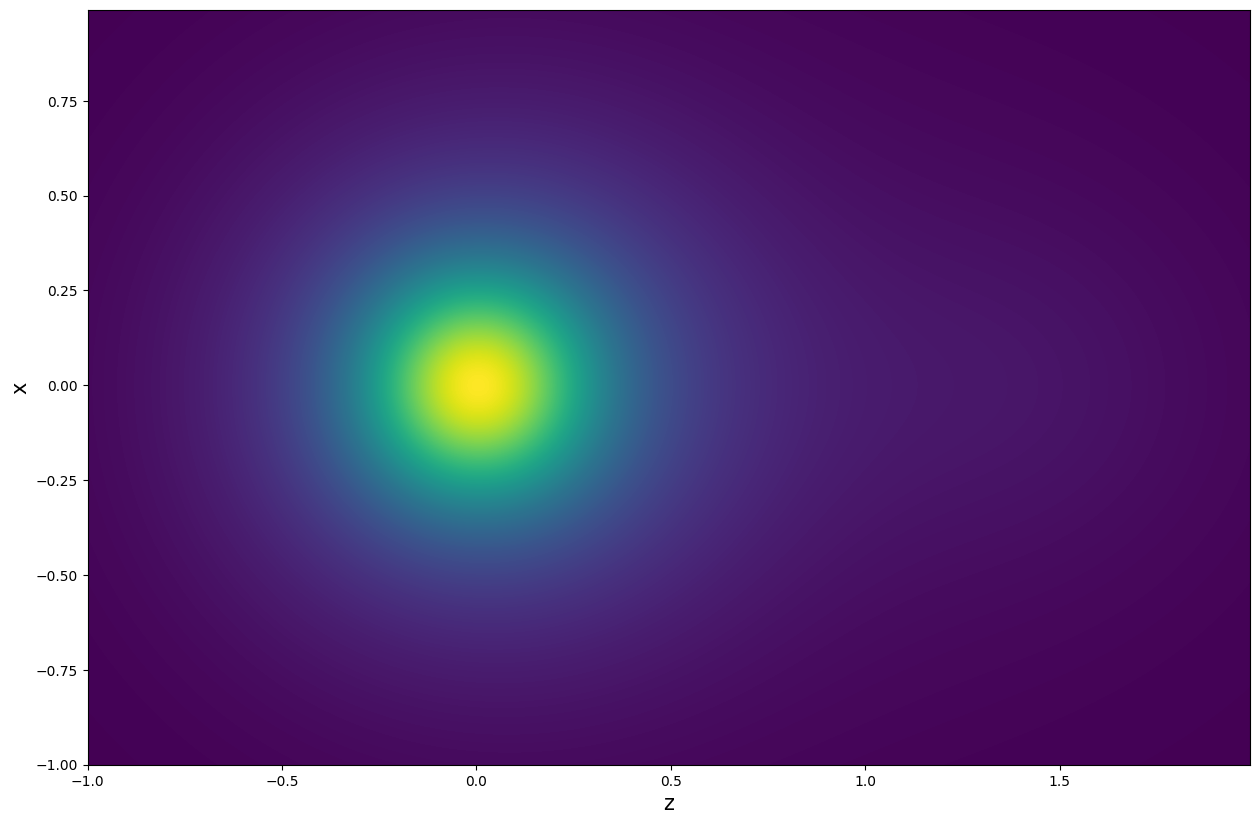

In [ ]:
#Begin the contour plot
plt.figure(figsize=(15,10), dpi=100)
plt.contourf(Z, X, groundstate_pd, 1000, cmap='viridis')        
plt.xlabel('z', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.show()

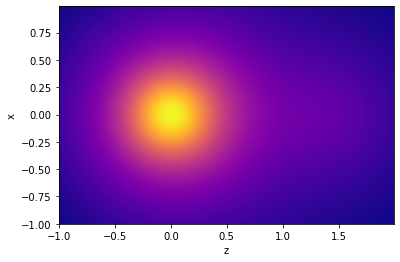

In [ ]:
#Try plotting each orbital separately on the same contour plot
fig, ax = plt.subplots(1,1)
# cp1 = ax.contourf(Z, X, (np.absolute(orb_HE))**2, 500)
cp2 = ax.contourf(Z, X, (np.absolute(orb_H))**2, 500)
# cp2 = ax.contourf(Z, X, bonding_orb, 500)


cp2 = ax.contourf(Z, X, np.absolute(bonding_orb), cmap='plasma', levels=200)

plt.xlabel('z')
plt.ylabel('x')
plt.show()

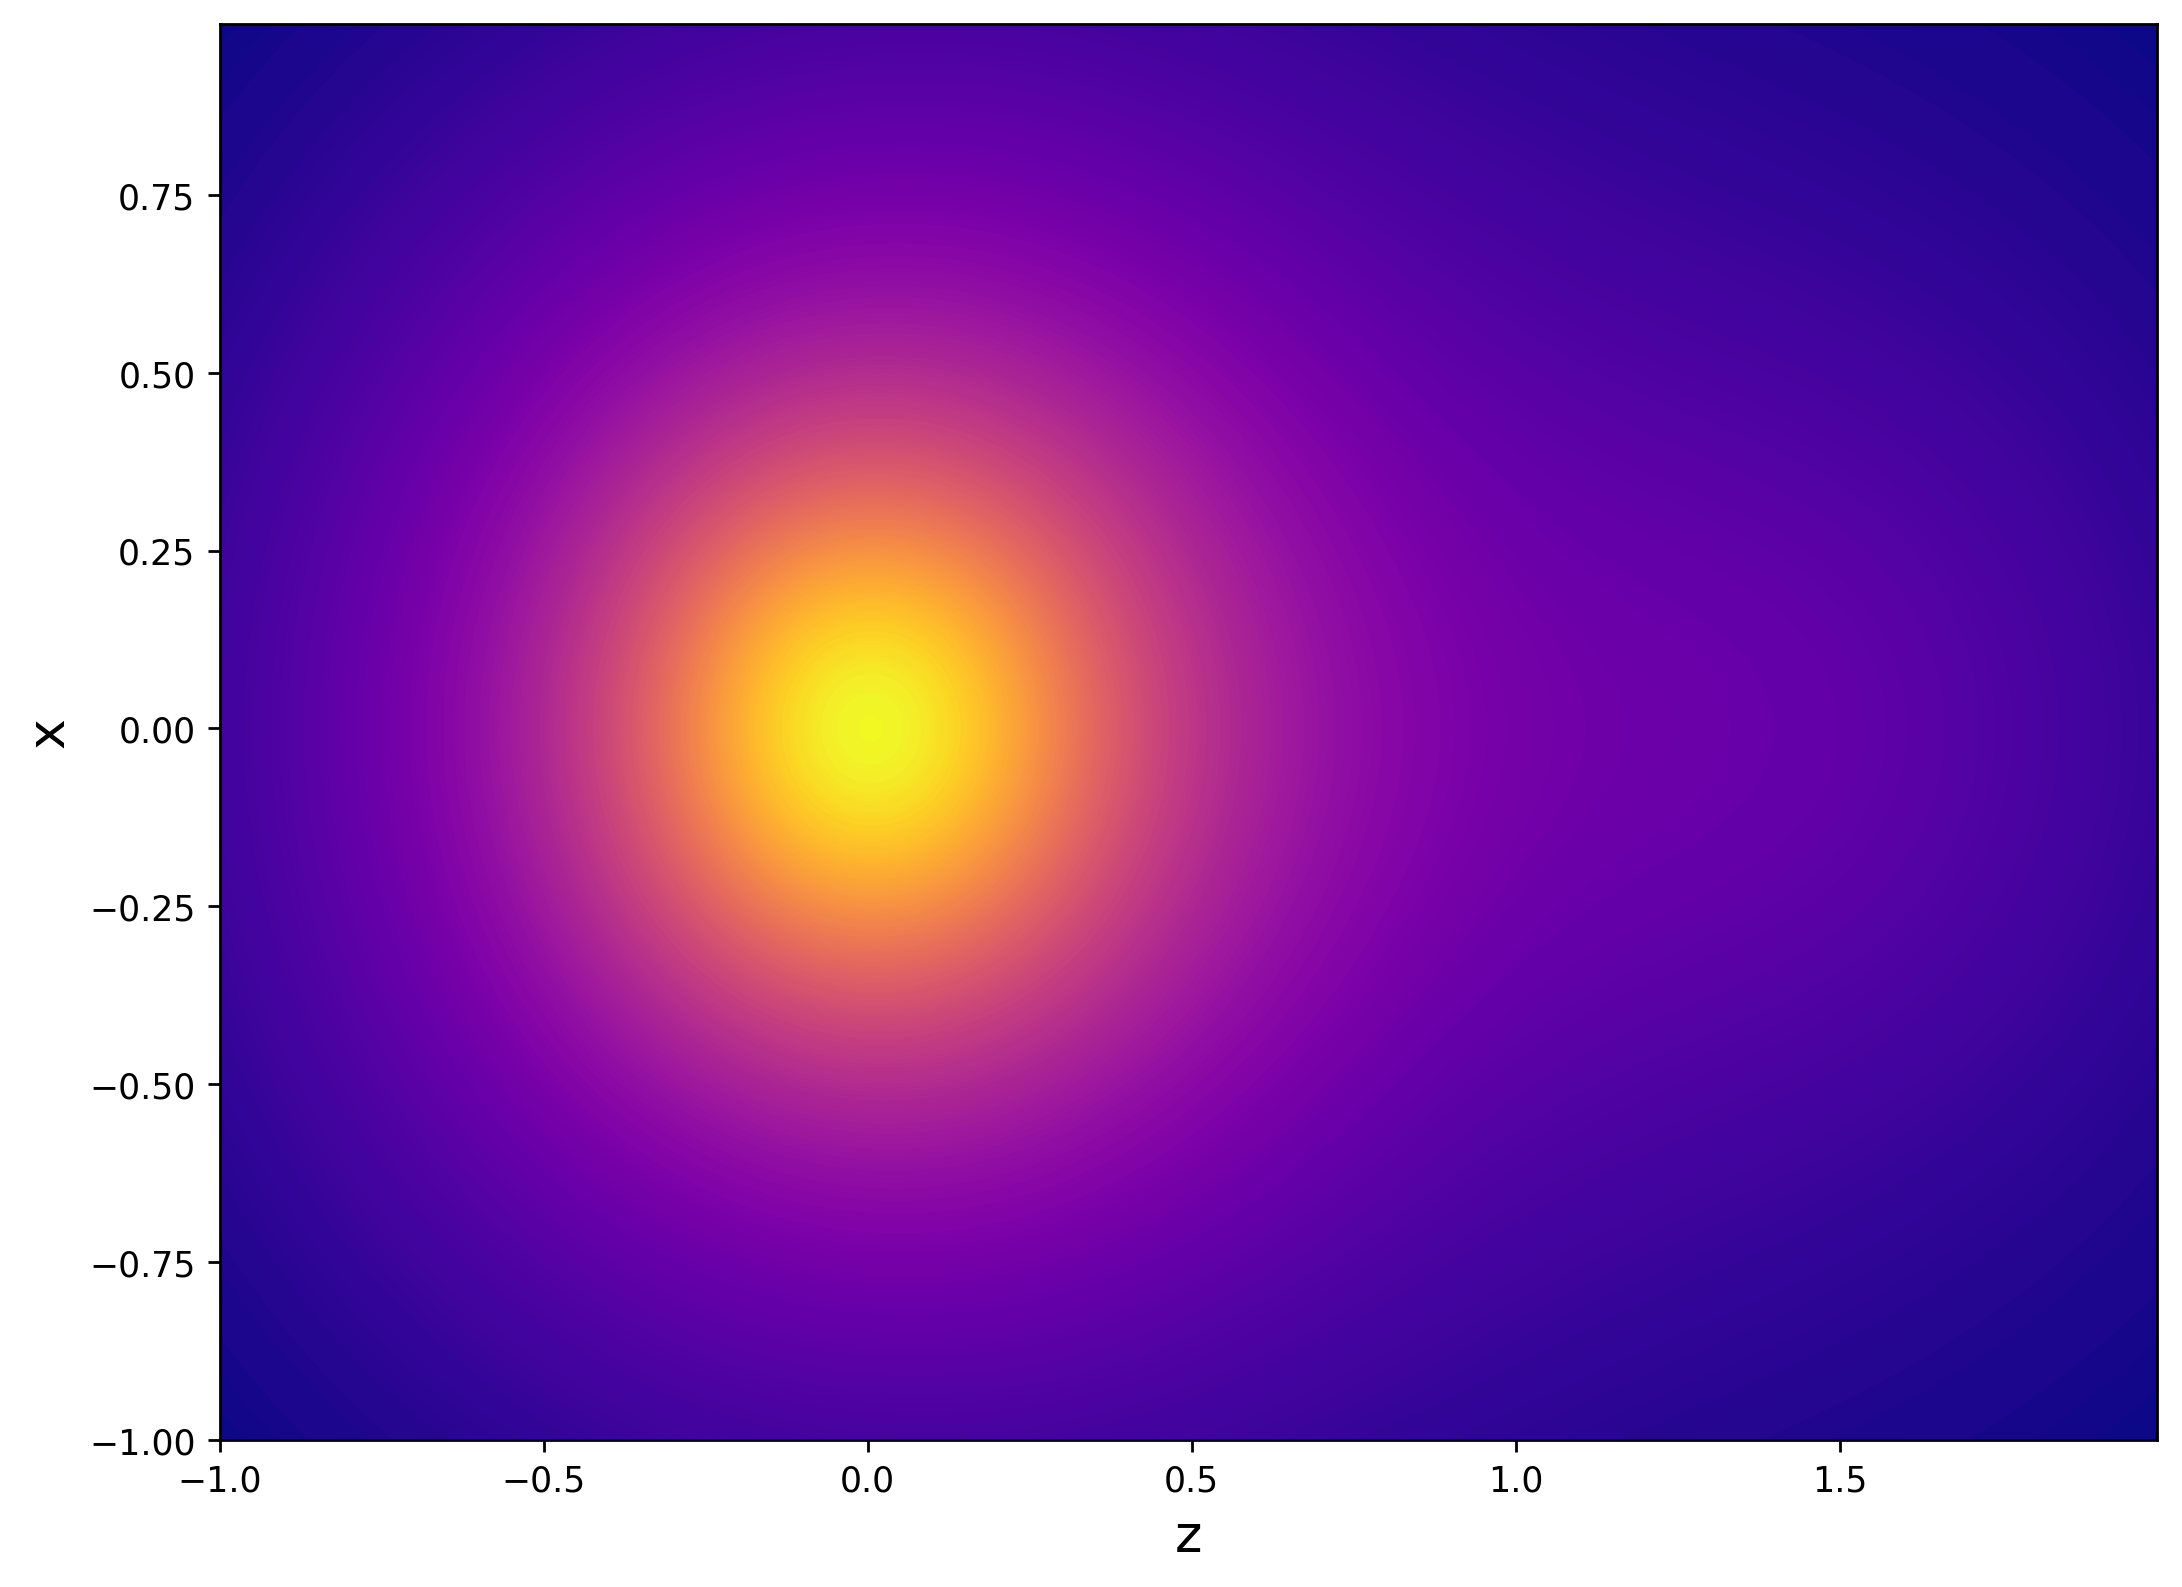

In [ ]:
plt.figure(figsize=(10,7.5), dpi=250)
plt.contourf(Z, X, np.absolute(bonding_orb), cmap='plasma', levels=200)
plt.xlabel('z', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.show()

# Auxiliary plots 

Plots to demonstrate the STO-3G basis 

In [ ]:
#Generate the values first going from the centre outwards
x=np.arange(0,2,0.01)

#Generate the slater orbital first 
slater_1s_HE = ((zeta_dict['He'][0]**3/np.pi)**0.5)*np.exp(-zeta_dict['He'][0]*np.abs(x))

#STO-1G orbital 
STO1G_HE = primitive_gaussian(x, 0, [0,0,0], 0.27, zeta_dict['He'][0])

#STO-2G orbital 
STO2G_HE = (0.68*primitive_gaussian(x, 0, [0,0,0], 0.15, zeta_dict['He'][0])+
            0.43*primitive_gaussian(x, 0, [0,0,0], 0.86, zeta_dict['He'][0]))

#STO-3G orbital
STO3G_HE = (D[0][0]*primitive_gaussian(x, 0, [0,0,0], alpha[0][0], zeta_dict['He'][0]) + 
            D[0][1]*primitive_gaussian(x, 0, [0,0,0], alpha[0][1], zeta_dict['He'][0]) +
            D[0][2]*primitive_gaussian(x, 0, [0,0,0], alpha[0][2], zeta_dict['He'][0]))

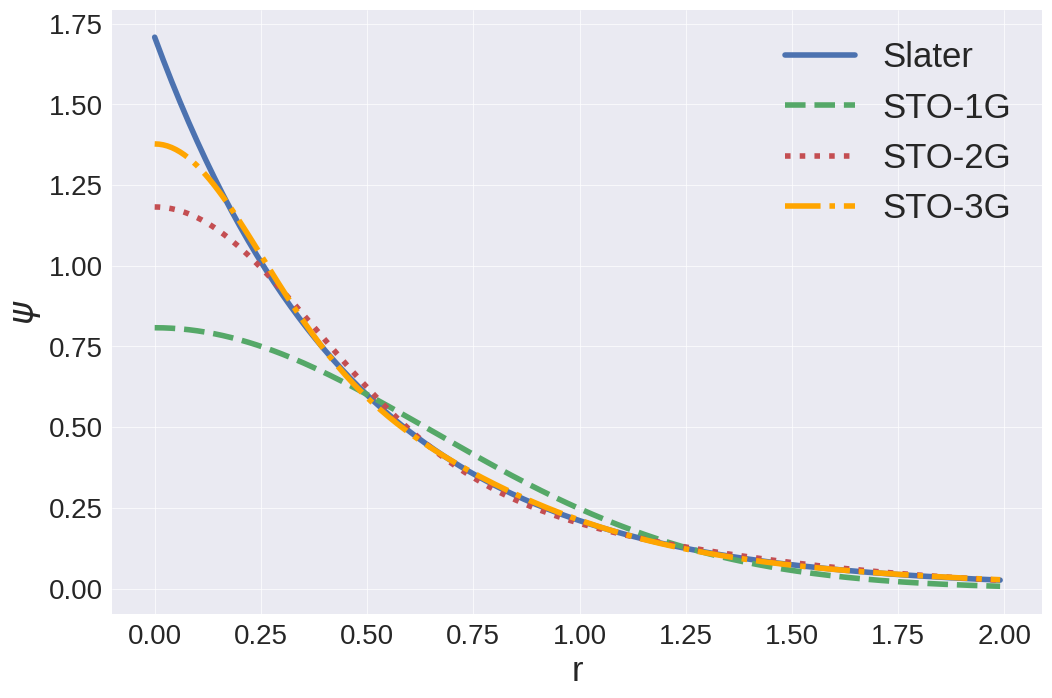

In [ ]:
plt.figure(figsize=(12,8), dpi=100)
plt.style.use('seaborn')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=25)
# plt.yticks([0,1.75])
# plt.xticks([0,1,2])
plt.plot(x, slater_1s_HE, label='Slater', linewidth=4)
plt.plot(x, STO1G_HE, label='STO-1G', linewidth=4, linestyle='--')
plt.plot(x, STO2G_HE, label='STO-2G', linewidth=4, linestyle=':')
plt.plot(x, STO3G_HE, label='STO-3G', color='orange', linewidth=4, linestyle='-.')
plt.xlabel('r', fontsize=25)
plt.ylabel(r'$\psi$', fontsize=25, rotation=90)
plt.legend()
plt.grid(linewidth=0.5)